# Project Title

Code by **Caroline Juang**, c.juang@columbia.edu

## Setup

In [1]:
# import
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.stats
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Import the data

In [176]:
# download the datasets needed
!wget -c 'https://www.ldeo.columbia.edu/~williams/US_fire/12km/wildfire/burnarea_combined.nc'
!wget -c 'https://www.ldeo.columbia.edu/~williams/US_fire/12km/landcover/US_ForestType_Ruefenacht/forest_type_frac.nc'
!wget -c 'https://www.ldeo.columbia.edu/~williams/US_fire/12km/climate/primary/ea.nc'
!wget -c 'https://www.ldeo.columbia.edu/~williams/US_fire/12km/climate/primary/es.nc'
!wget -c 'https://www.ldeo.columbia.edu/~williams/US_fire/12km/landcover/ecoregions/epa_level2.nc'

--2020-11-15 00:21:18--  https://www.ldeo.columbia.edu/~williams/US_fire/12km/wildfire/burnarea_combined.nc
Resolving www.ldeo.columbia.edu (www.ldeo.columbia.edu)... 129.236.14.15
Connecting to www.ldeo.columbia.edu (www.ldeo.columbia.edu)|129.236.14.15|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2020-11-15 00:21:19--  https://www.ldeo.columbia.edu/~williams/US_fire/12km/landcover/US_ForestType_Ruefenacht/forest_type_frac.nc
Resolving www.ldeo.columbia.edu (www.ldeo.columbia.edu)... 129.236.14.15
Connecting to www.ldeo.columbia.edu (www.ldeo.columbia.edu)|129.236.14.15|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2020-11-15 00:21:20--  https://www.ldeo.columbia.edu/~williams/US_fire/12km/climate/primary/ea.nc
Resolving www.ldeo.columbia.edu (www.ldeo.columbia.edu)... 

In [177]:
# import fire data and get variables
burnarea_data = xr.open_dataset('burnarea_combined.nc')
# burnarea = burnarea_data.burnarea
time_str = burnarea_data.time
X = burnarea_data.X
Y = burnarea_data.Y

# import ecoregion data
ecoregion_data = xr.open_dataset('epa_level2.nc')
# drop the bad ecoregion
ecoregion_data = ecoregion_data.sel(province=[0,1,2,3,5,6,7,8,9], drop=True)
ecoregion_legend = ecoregion_data.ecoregion
epa_l2 = ecoregion_data.epa_level2

# import forested area
forest_type_data = xr.open_dataset('forest_type_frac.nc')
ftype = forest_type_data.ftype

In [198]:
# import vapor pressure data
ea_data = xr.open_dataset('ea.nc')
# import saturation vapor pressure data
es_data = xr.open_dataset('es.nc')

# calculate vapor pressure deficit
vpd = es_data.es - ea_data.ea

# limit dataset to the same timeframe as burnarea data
vpdcurrent = vpd.loc["1984-01-15":"2018-12-15"]

## Forested and Non-Forested area

How much do forests matter to burned area?

### Get burned area in forests and not in forests

In [178]:
# storage
forest = np.zeros((len(Y), len(X)), np.single)

# add up the forest percentages for each forest type
for index,number in enumerate(ftype):
    forest = forest + forest_type_data.forest_type_frac[index,:,:]

# remove forest_type_data netCDF
forest_type_data = None

# get burned area in forest
burnforest = burnarea_data * forest

In [4]:
# get non-forested burned area using fractional difference
burnxforest = burnarea_data * (1-forest)

In [5]:
# get time-sum spatial burn area
burnforesttime = burnforest.sum(dim='time')
burnxforesttime = burnxforest.sum(dim='time')

# mask the array to remove plotting where there is 0 burned area
burnforesttime2 = np.ma.masked_where(burnforesttime.burnarea.values==0, burnforesttime.burnarea)
burnxforesttime2 = np.ma.masked_where(burnxforesttime.burnarea.values==0, burnxforesttime.burnarea)

### Visualize forested and non-forested burned area

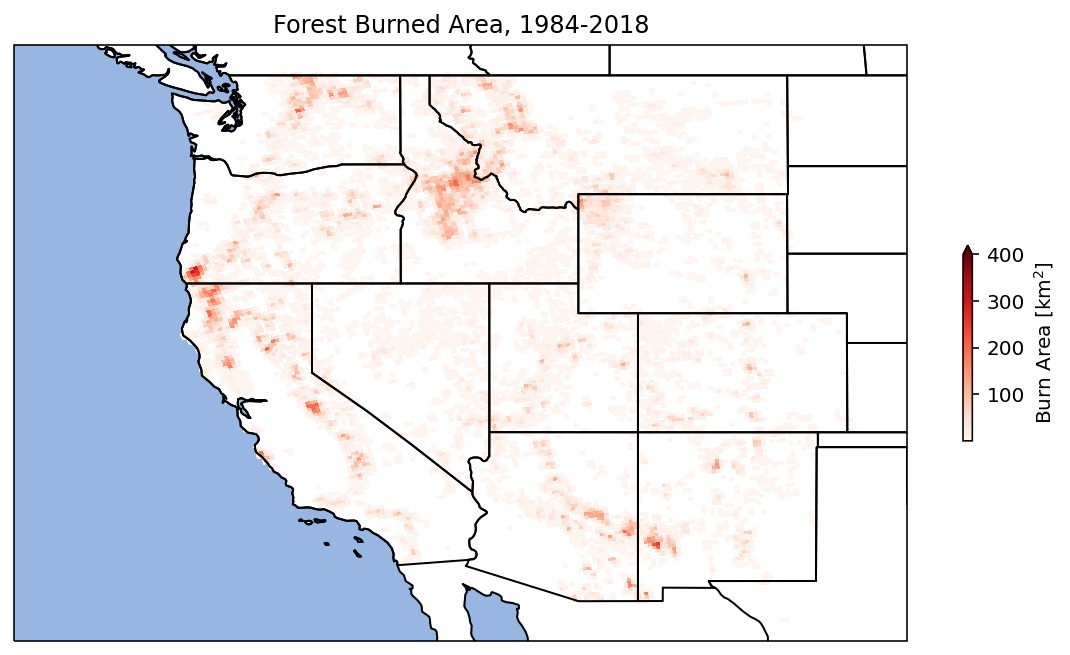

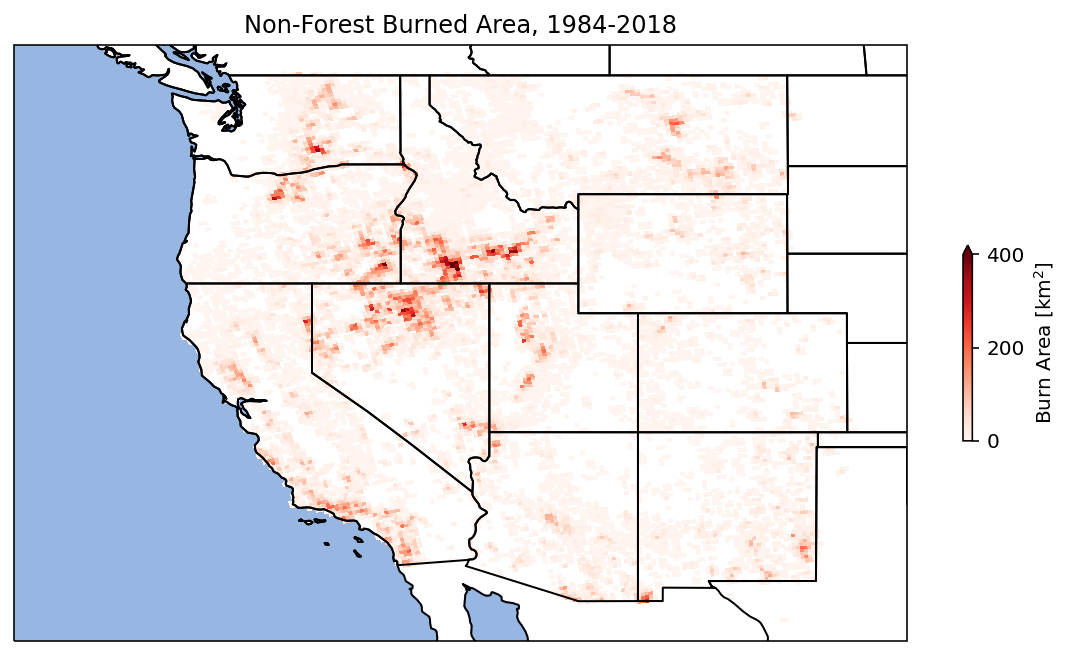

In [61]:
# visualize forested and non forested burned area

# define map extent
extent = [-130,-100,30,50]

# plot
fig, ax1 = plt.subplots(figsize=(10,6), subplot_kw={'projection': ccrs.PlateCarree()})
# setup map
ax1.set_extent(extent, ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE, edgecolor='black', zorder=9)
ax1.add_feature(cfeature.STATES, edgecolor='black', zorder=10)
ax1.add_feature(cfeature.OCEAN)

# plot data
burnmapfo = ax1.pcolormesh(burnforesttime.X, burnforesttime.Y, burnforesttime2, cmap='Reds', vmax=400,
                           transform=ccrs.epsg(5070))
# decorate
ax1.set_title('Forest Burned Area, 1984-2018')

bar1 = fig.colorbar(burnmapfo, ax=ax1, shrink=0.30, extend='max')
bar1.set_label('Burn Area [km$^2$]')

# plot 
fig, ax2 = plt.subplots(figsize=(10,6), subplot_kw={'projection':ccrs.PlateCarree()})
ax2.set_extent(extent, ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE, edgecolor='black', zorder=9)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=10)
ax2.add_feature(cfeature.OCEAN)

# plot data
burnmapxfo = ax2.pcolormesh(burnxforesttime.X, burnxforesttime.Y, burnxforesttime2, cmap='Reds', vmax=400,
                            transform=ccrs.epsg(5070))
# decorate
ax2.set_title('Non-Forest Burned Area, 1984-2018')
bar2 = fig.colorbar(burnmapxfo, ax=ax2, shrink=0.30, extend='max')
bar2.set_label('Burn Area [km$^2$]')

### Visualize (coarse) annual burned area

In [31]:
# resample to get burned area by year
burnforest_all = burnarea_data.resample(indexer={'time':'Y'}).sum().sum(dim=['X','Y'])
burnforest_y = burnforest.resample(indexer={'time':'Y'}).sum().sum(dim=['X','Y'])
burnxforest_y = burnxforest.resample(indexer={'time':'Y'}).sum().sum(dim=['X','Y'])

In [22]:
# setup
# years in dataset
yrmin = 1984
yrmax = 2018

# make list of years
years = np.arange(yrmin, yrmax+1)
months = np.arange(1,12+1) # months
nyears = yrmax-yrmin

In [66]:
# make DataFrame of the annual burn area for plotting
df = pd.DataFrame({'years': years, 'forest': burnforest_y.burnarea.values, 
                   'non-forest': burnxforest_y.burnarea.values, 
                   'all burn area': burnforest_all.burnarea.values})

In [69]:
# calculate the linear line of best fit
burnallm, burnallb = np.polyfit(df.years, df['all burn area'], 1)
burnfom, burnfob = np.polyfit(df.years, df.forest, 1)
burnxfom, burnxfob = np.polyfit(df.years, df['non-forest'], 1)

(1984.0, 2018.0)

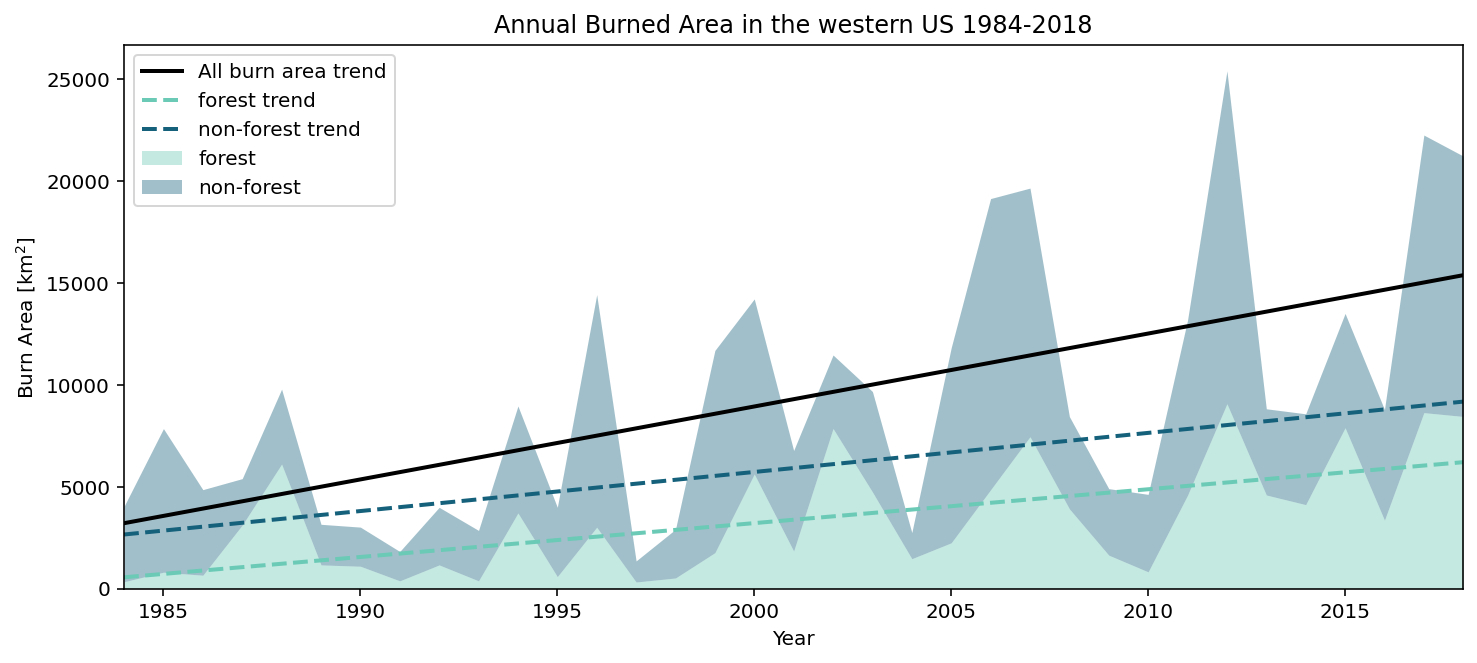

In [79]:
# colors
palette = ['#6bcab6', '#15617c']

# plot data
fig, ax = plt.subplots(figsize=(12,5))
df.plot.area(x='years', y=['forest','non-forest'], color=palette, alpha=0.4, linewidth=0, ax=ax)

# plot line of best fit
ax.plot(years, (burnallm*years + burnallb), color='k', linewidth=2, label='All burn area trend')
ax.plot(years, (burnfom*years + burnfob), '--', color=palette[0], linewidth=2, label='forest trend')
ax.plot(years, (burnxfom*years + burnxfob), '--', color=palette[1], linewidth=2, label='non-forest trend')

# decorate
ax.legend(loc='upper left')
ax.set_title('Annual Burned Area in the western US 1984-2018')
ax.set_ylabel('Burn Area [km$^2$]')
ax.set_xlabel('Year');
ax.set_xlim([1984,2018])

### Break down by Ecoregion

In [132]:
epa_l2

<xarray.DataArray 'epa_level2' (province: 9, Y: 208, X: 155)>
[290160 values with dtype=float32]
Coordinates:
  * X        (X) float64 -2.353e+06 -2.341e+06 ... -5.172e+05 -5.052e+05
  * Y        (Y) float64 3.172e+06 3.16e+06 3.148e+06 ... 6.995e+05 6.875e+05
Dimensions without coordinates: province
Attributes:
    long_name:  fraction of grid cell within each EPA level-2 ecoregion
    units:      unitless

In [133]:
ecoregion_legend.legend

'1: COLD DESERTS, 2: MARINE WEST COAST FOREST, 3: MEDITERRANEAN CALIFORNIA, 4: SOUTH CENTRAL SEMIARID PRAIRIES, 5: TEMPERATE PRAIRIES, 6: UPPER GILA MOUNTAINS, 7: WARM DESERTS, 8: WEST-CENTRAL SEMIARID PRAIRIES, 9: WESTERN CORDILLERA, 10: WESTERN SIERRA MADRE PIEDMONT'

### Get burned area yearly

In [143]:
# create container for month sums of burned area
month_burnfo = np.zeros((len(time_str), len(epa_l2)))
month_burnxfo = np.zeros((len(time_str), len(epa_l2)))

# get monthly burned data by region
for index, region in enumerate(epa_l2):
    tmpburnarea_fo = burnforest.burnarea * region
    tmpburnarea_xfo = burnxforest.burnarea * region
    month_burnfo[:, index] = tmpburnarea_fo.sum(dim=('Y','X'))
    month_burnxfo[:, index] = tmpburnarea_xfo.sum(dim=('Y','X'))
    
# create new DataArrays
month_burnfo = xr.DataArray(month_burnfo, coords=[time_str, ecoregion_legend], dims=['time', 'ecoregion'])
month_burnxfo = xr.DataArray(month_burnxfo, coords=[time_str, ecoregion_legend], dims=['time', 'ecoregion'])

In [144]:
# check out monthly rolling fire threshold in burn area by month
burnfomoroll = month_burnfo.rolling(time=3).sum()
burnxfomoroll = month_burnxfo.rolling(time=3).sum()

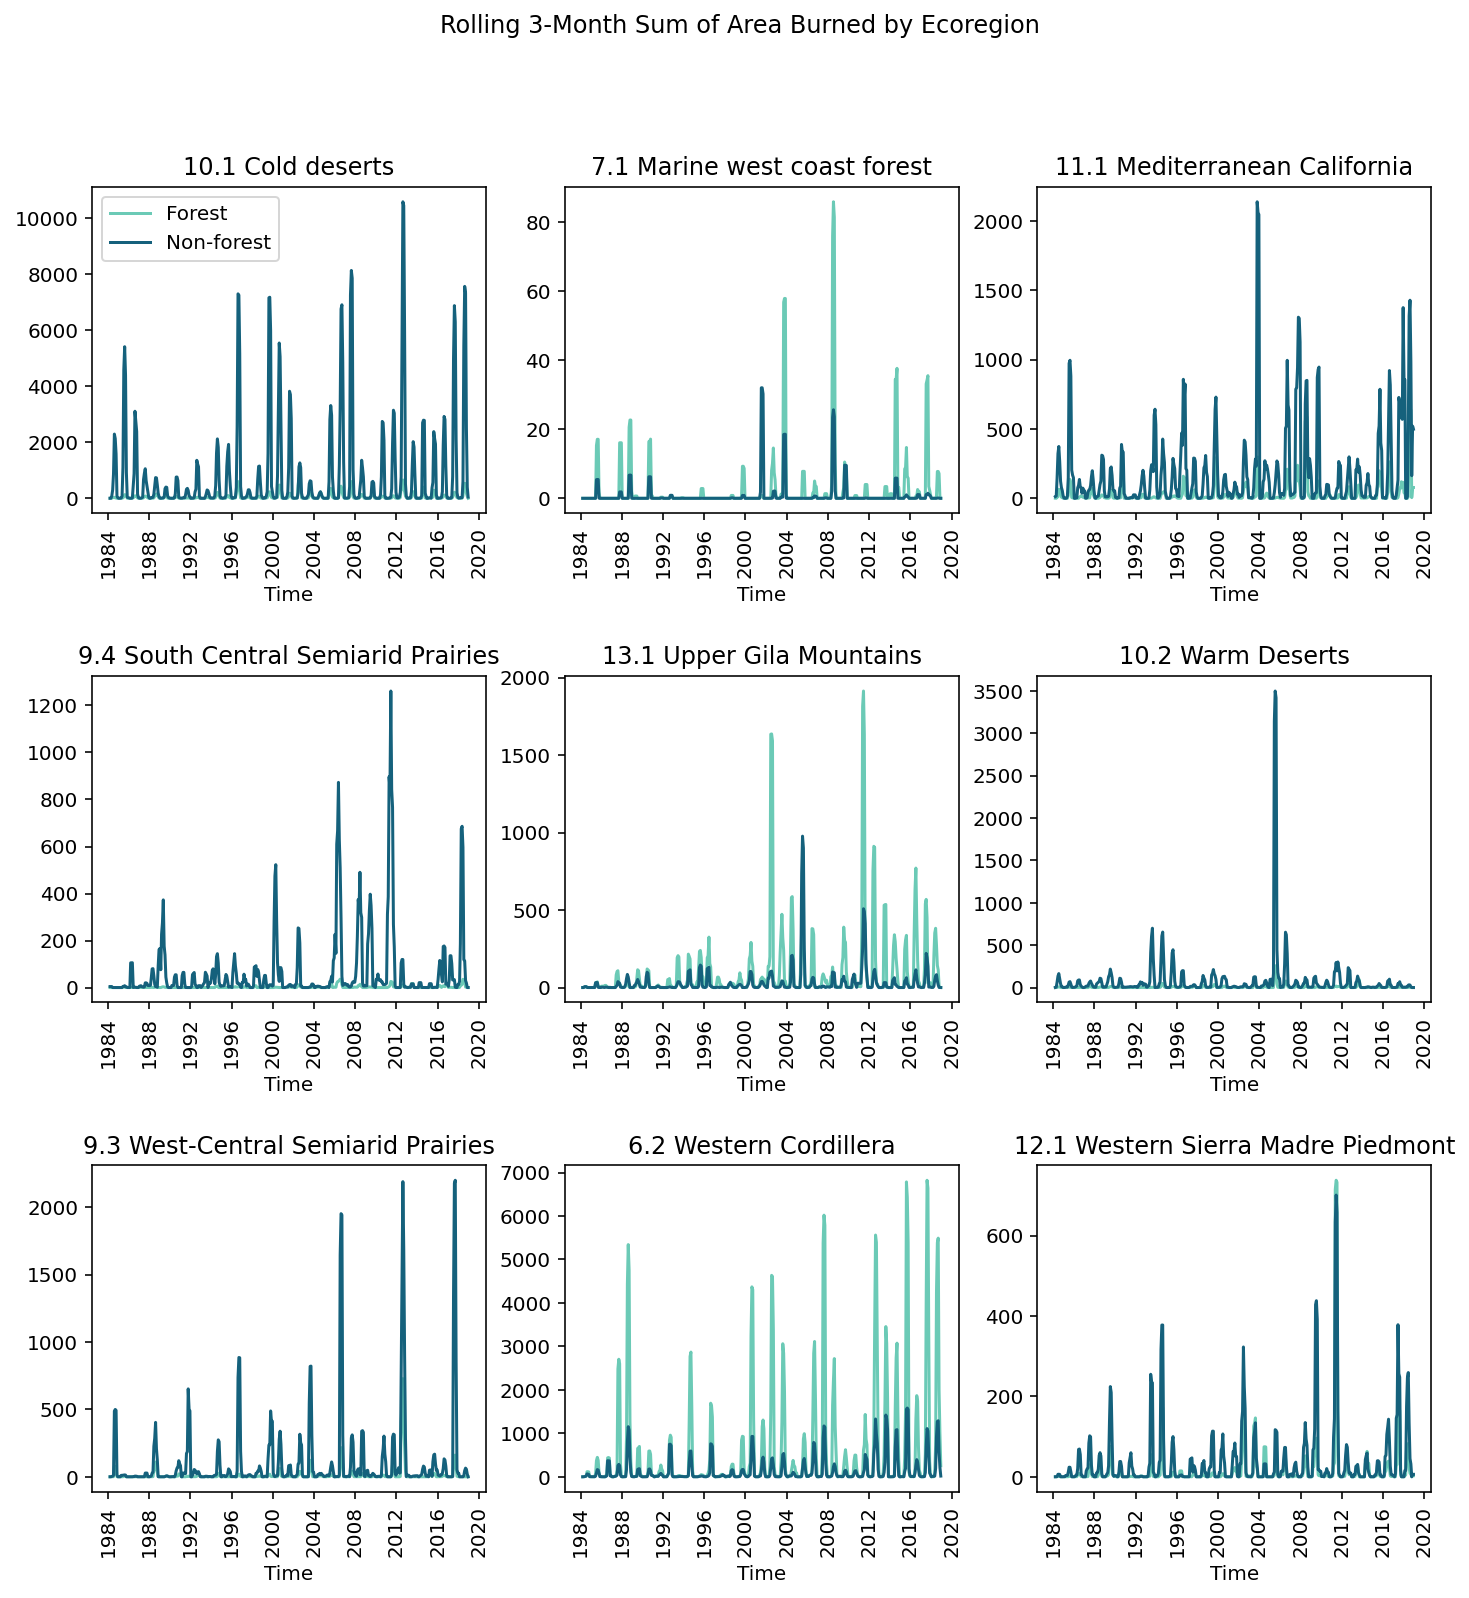

In [156]:
# plot the monthly rolling fire threshold for forested area

# colors from Set1 colormap
regionpalette = ('#e41a1c','#a65628','#ffd92f','#f781bf', '#ff7f00','#377eb8', '#999999', '#4daf4a','#984ea3')

# plot
fig, ax = plt.subplots(3,3, figsize=(12,12))

counter = 0
for index in range(0,3):
    for jndex in range(0,3):
        ax[index,jndex].plot(burnfomoroll.time, burnfomoroll.isel(ecoregion=counter), color=palette[0], zorder=2, label='Forest')
        ax[index, jndex].plot(burnxfomoroll.time, burnxfomoroll.isel(ecoregion=counter), color=palette[1], zorder=3, label='Non-forest')
        counter+=1
        
# decorate plots
ax[0,0].set_title('10.1 Cold deserts')
ax[0,1].set_title('7.1 Marine west coast forest')
ax[0,2].set_title('11.1 Mediterranean California')
ax[1,0].set_title('9.4 South Central Semiarid Prairies')
ax[1,1].set_title('13.1 Upper Gila Mountains')
ax[1,2].set_title('10.2 Warm Deserts')
ax[2,0].set_title('9.3 West-Central Semiarid Prairies')
ax[2,1].set_title('6.2 Western Cordillera')
ax[2,2].set_title('12.1 Western Sierra Madre Piedmont')

# iterate and plot labels
for index in range(0,3):
    for jndex in range(0,3):
        plt.setp(ax[index,jndex].get_xticklabels(), rotation=90, horizontalalignment='center')
        ax[index,jndex].set_xlabel('Time')
        ax[index,jndex].set_ylabel('')
        
ax[0,0].legend(loc='upper left')
plt.suptitle('Rolling 3-Month Sum of Area Burned by Ecoregion')
plt.subplots_adjust(hspace = 0.5)

In [165]:
# get quantile of fires for each region
quanvalue = 0.75
# check out monthly rolling fire threshold in burn area by month
tmpquantfo = burnfomoroll.quantile(quanvalue, dim='time')
tmpquantxfo = burnfomoroll.quantile(quanvalue, dim='time')

# use quantile to create a mask for the dataset
# iterate through the dataset
tmpmaskfo = burnfomoroll > tmpquantfo
tmpmaskxfo = burnxfomoroll > tmpquantxfo

In [201]:
# TODO get vpd by region, use mask on VPD, then look at the graphs